In [1]:
import os
import sys
import gc

import time
import json
import random
import math
import numpy as np

import torch
from torch.optim.adamw import AdamW
from torch.nn.utils import clip_grad_norm_
import torch.distributed as dist
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import save_image


from wolf.data import load_datasets, get_batch, preprocess, postprocess
from wolf import WolfModel
from wolf.utils import total_grad_norm
from wolf.optim import ExponentialScheduler

from experiments.options import parse_args

from matplotlib import pyplot as plt

from tqdm import tqdm_notebook

import autoreload
%load_ext autoreload
%autoreload 2

In [2]:
def is_master(rank):
    return rank <= 0

def is_distributed(rank):
    return rank >= 0

def logging(info, logfile=None):
    print(info)
    if logfile is not None:
        print(info, file=logfile)
        logfile.flush()

In [3]:
def init_dataloader(args, train_data, val_data):
    if is_distributed(args.rank):
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_data, rank=args.rank,
                                                                        num_replicas=args.world_size,
                                                                        shuffle=True)
    else:
        train_sampler = None
    train_loader = DataLoader(train_data, batch_size=args.batch_size,
                              shuffle=(train_sampler is None), sampler=train_sampler,
                              num_workers=args.workers, pin_memory=True, drop_last=True)
    if is_master(args.rank):
        eval_batch = args.eval_batch_size
        val_loader = DataLoader(val_data, batch_size=eval_batch, shuffle=False,
                                num_workers=args.workers, pin_memory=True)
    else:
        val_loader = None

    return train_loader, train_sampler, val_loader

In [4]:
def setup(args):
    def check_dataset():
        if dataset == 'cifar10':
            assert image_size == 32, 'CIFAR-10 expected image size 32 but got {}'.format(image_size)
        elif dataset.startswith('lsun'):
            assert image_size in [128, 256]
        elif dataset == 'celeba':
            assert image_size in [256, 512]
        elif dataset == 'imagenet':
            assert image_size in [64, 128, 256]

    dataset = args.dataset
    if args.category is not None:
        dataset = dataset + '_' + args.category
    image_size = args.image_size
    check_dataset()

    nc = 3
    args.nx = image_size ** 2 * nc
    n_bits = args.n_bits
    args.n_bins = 2. ** n_bits
    args.test_k = 1

    model_path = args.model_path
    args.checkpoint_name = os.path.join(model_path, 'checkpoint')

    result_path = os.path.join(model_path, 'images')
    args.result_path = result_path
    data_path = args.data_path

    if is_master(args.rank):
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        if not os.path.exists(result_path):
            os.makedirs(result_path)
        if args.recover < 0:
            args.log = open(os.path.join(model_path, 'log.txt'), 'w')
        else:
            args.log = open(os.path.join(model_path, 'log.txt'), 'a')
    else:
        args.log = None

    args.cuda = torch.cuda.is_available()
    random_seed = args.seed + args.rank if args.rank >= 0 else args.seed
    if args.recover >= 0:
        random_seed += random.randint(0, 1024)
    logging("Rank {}: random seed={}".format(args.rank, random_seed), logfile=args.log)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    device = torch.device('cuda', args.local_rank) if args.cuda else torch.device('cpu')
    if args.cuda:
        torch.cuda.set_device(device)
        torch.cuda.manual_seed(random_seed)

    torch.backends.cudnn.benchmark = True

    args.world_size = int(os.environ["WORLD_SIZE"]) if is_distributed(args.rank) else 1
    logging("Rank {}: ".format(args.rank) + str(args), args.log)

    train_data, val_data = load_datasets(dataset, image_size, data_path=data_path)
    train_index = np.arange(len(train_data))
    np.random.shuffle(train_index)
    val_index = np.arange(len(val_data))

    if is_master(args.rank):
        logging('Data size: training: {}, val: {}'.format(len(train_index), len(val_index)))

    if args.recover >= 0:
        params = json.load(open(os.path.join(model_path, 'config.json'), 'r'))
    else:
        params = json.load(open(args.config, 'r'))
        json.dump(params, open(os.path.join(model_path, 'config.json'), 'w'), indent=2)

    wolf = WolfModel.from_params(params)
    wolf.to_device(device)
    args.device = device
    
    if args.recover >= 0:
        wolf = WolfModel.load(args.model_path, args.device, 0)

    return args, (train_data, val_data), (train_index, val_index), wolf

In [5]:
debug=False

def eval(args, val_loader, wolf):
    wolf.eval()
    wolf.sync()
    gnll = 0
    nent = 0
    kl = 0
    num_insts = 0
    device = args.device
    n_bits = args.n_bits
    n_bins = args.n_bins
    nx = args.nx
    test_k = args.test_k
    
    results = []

    for step, (data, y) in enumerate(val_loader):
        batch_size = len(data)
        data = data.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.no_grad():
            wolf.loss(data, y=y, n_bits=n_bits, nsamples=test_k)
#         print('shape is ', attns.shape)
        
#         del attns
#         gc.collect()
#         size_bool = True
#         for attn_idx in range(len(attns_)-1):
#             size_bool = (size_bool and (attns_[attn_idx].shape == attns_[attn_idx].shape))
#         if debug:
#             if size_bool:
#                 print('the length of attentions is {}; the shape of attention is {}'.format(len(attns_), attns_[0].shape))
#             else:
#                 print('Size not matched')
#         gnll += loss_gen.sum().item()
#         kl += loss_kl.sum().item()
#         nent += loss_dequant.sum().item()
#         num_insts += batch_size
        
#         results.append((data.to('cpu'), y.to('cpu'), attns.to('cpu')))
        results.append((data.to('cpu'), y.to('cpu')))
        
        if step % 10 == 0:
            print('Step: ', step)
            torch.cuda.empty_cache()

#     gnll = gnll / num_insts
#     nent = nent / num_insts
#     kl = kl / num_insts
#     nll = gnll + kl + nent + np.log(n_bins / 2.) * nx
#     bpd = nll / (nx * np.log(2.0))
#     nepd = nent / (nx * np.log(2.0))
#     logging('Avg  NLL: {:.2f}, KL: {:.2f}, NENT: {:.2f}, BPD: {:.4f}, NEPD: {:.4f}'.format(
#         nll, kl, nent, bpd, nepd), args.log)
    return results

In [6]:
def main(args):
    args, (train_data, val_data), (train_index, val_index), wolf = setup(args)

    train_loader, train_sampler, val_loader = init_dataloader(args, train_data, val_data)

    return eval(args, val_loader, wolf), wolf

In [7]:
args_dict = {'rank': -1,
 'local_rank': 0,
 'config': 'experiments/configs/cifar10/glow/glow-cat-uni-condconv.json',
 'batch_size': 256,
 'eval_batch_size': 512,
 'batch_steps': 2,
 'init_batch_size': 1024,
 'epochs': 100,
 'valid_epochs': 10,
 'seed': 65537,
 'train_k': 1,
 'log_interval': 10,
 'lr': 0.001,
 'warmup_steps': 50,
 'lr_decay': 0.999997,
 'beta1': 0.9,
 'beta2': 0.999,
 'eps': 1e-08,
 'weight_decay': 1e-06,
 'amsgrad': False,
 'grad_clip': 0.0,
 'dataset': 'cifar10',
 'category': None,
 'image_size': 32,
 'workers': 4,
 'n_bits': 8,
 'model_path': 'experiments/models/glow/cifar_linear_condconv_model/',
 'data_path': 'experiments/data/cifar_data',
 'recover': 0,
}

from argparse import Namespace

args = Namespace(**args_dict)

In [8]:
results, wolf = main(args)

Rank -1: random seed=66225
Rank -1: Namespace(amsgrad=False, batch_size=256, batch_steps=2, beta1=0.9, beta2=0.999, category=None, checkpoint_name='experiments/models/glow/cifar_linear_condconv_model/checkpoint', config='experiments/configs/cifar10/glow/glow-cat-uni-condconv.json', cuda=True, data_path='experiments/data/cifar_data', dataset='cifar10', epochs=100, eps=1e-08, eval_batch_size=512, grad_clip=0.0, image_size=32, init_batch_size=1024, local_rank=0, log=<_io.TextIOWrapper name='experiments/models/glow/cifar_linear_condconv_model/log.txt' mode='a' encoding='UTF-8'>, log_interval=10, lr=0.001, lr_decay=0.999997, model_path='experiments/models/glow/cifar_linear_condconv_model/', n_bins=256.0, n_bits=8, nx=3072, rank=-1, recover=0, result_path='experiments/models/glow/cifar_linear_condconv_model/images', seed=65537, test_k=1, train_k=1, valid_epochs=10, warmup_steps=50, weight_decay=1e-06, workers=4, world_size=1)
Files already downloaded and verified
Data size: training: 50000, 

In [9]:
data_1, label_1 = results[0]

In [10]:
data_1.shape

torch.Size([512, 3, 32, 32])

In [11]:
label_1.shape

torch.Size([512])

In [12]:
def reconstruct(args, img, y1, y2, wolf):
    print('reconstruct')
    wolf.eval()
    batch = 1
    nsamples = 15

#     index = np.arange(len(data))
#     np.random.shuffle(index)
#     img, y = get_batch(data, index[:batch])
    img = img.to(args.device)
    y1 = y1.to(args.device)
    y2 = y2.to(args.device)
    
    with torch.no_grad():
        image_size = (3, args.image_size, args.image_size)
        _, epsilon1 = wolf.encode(img, y=y1, n_bits=args.n_bits, nsamples=nsamples, random=False)
        epsilon1 = epsilon1.view(batch * nsamples, *image_size)
        z1 = wolf.encode_global(img, y=y1, n_bits=args.n_bits, nsamples=nsamples, random=False)
        z1 = z1.view(batch * nsamples, z1.size(2))
        # [batch, nsamples, c, h, w]
        img_recon1 = wolf.decode(epsilon1, z=z1, n_bits=args.n_bits).view(batch, nsamples, *image_size)
        
        _, epsilon2 = wolf.encode(img, y=y1, n_bits=args.n_bits, nsamples=nsamples, random=False)
        epsilon2 = epsilon2.view(batch * nsamples, *image_size)
        z2 = wolf.encode_global(img, y=y2, n_bits=args.n_bits, nsamples=nsamples, random=False)
        z2 = z2.view(batch * nsamples, z2.size(2))
        # [batch, nsamples, c, h, w]
        img_recon2 = wolf.decode(epsilon2, z=z2, n_bits=args.n_bits).view(batch, nsamples, *image_size)
        
        # [batch, 1, c, h, w]
        img = postprocess(preprocess(img, args.n_bits), args.n_bits).unsqueeze(1)
    
    fig, axs = plt.subplots(1,3)
    img_cpu = img.cpu()
    img_recon1_cpu = img_recon1.cpu()
    img_recon2_cpu = img_recon2.cpu()

    axs[0].imshow(img_cpu[0][0].permute(1, 2, 0))
    axs[1].imshow(img_recon1_cpu[0][0].permute(1, 2, 0))
    axs[2].imshow(img_recon2_cpu[0][0].permute(1, 2, 0))
    print('Recon1 and Origin: ', torch.norm(img_recon1_cpu[0][0] - img_cpu[0][0]))
    print('Recon2 and Origin: ', torch.norm(img_recon2_cpu[0][0] - img_cpu[0][0]))
    print('Recon1 and Recons: ', torch.norm(img_recon1_cpu[0][0] - img_recon2_cpu[0][0]))
    print('eps shape: ', epsilon1.shape)
    print('z shape: ', z1.shape)
    print('z1 and z2: ', torch.norm(z1 - z2))
    print('eps1 and eps2: ', torch.norm(epsilon1 - epsilon2))

    # [batch, nsamples + 1, c, h, w] -> [batch*(nsamples + 1), c, h, w]
#     comparison = torch.cat([img, img_recon], dim=1).view(-1, *image_size).cpu()

airplane : 0
automobile : 1
bird : 2
cat : 3
deer : 4
dog : 5
frog : 6
horse : 7
ship : 8
truck : 9

tensor(6)
reconstruct
Recon1 and Origin:  tensor(0.1475)
Recon2 and Origin:  tensor(4.6908)
Recon1 and Recons:  tensor(4.7782)
eps shape:  torch.Size([15, 3, 32, 32])
z shape:  torch.Size([15, 32])
z1 and z2:  tensor(0.2175, device='cuda:0')
eps1 and eps2:  tensor(0., device='cuda:0')


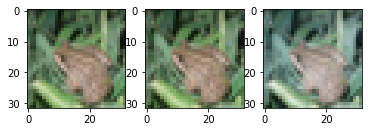

In [13]:
data_1, label_1 = results[0]
y_1_ = results[0][1]
print(label_1[4])
reconstruct(args, data_1[4].unsqueeze(0), label_1[4].unsqueeze(0), torch.LongTensor([2]), wolf)

In [14]:
torch.norm(wolf.core.generator.flow.blocks[0].steps[0].unit.coupling1_up.net.conv1.scale_proj.weight)

tensor(6.5033, device='cuda:0', grad_fn=<NormBackward0>)

In [15]:
def switch_operation(args, img1, img2, y1, y2, wolf):
    print('switch operation')
    batch = 1
    nsamples = 1
    image_size = (3, args.image_size, args.image_size)
    
    with torch.no_grad():
        img1 = img1.to(args.device).unsqueeze(0)
        img2 = img2.to(args.device).unsqueeze(0)

        y1 = y1.to(args.device).unsqueeze(0)
        y2 = y2.to(args.device).unsqueeze(0)

        nsamples = 1

        z1, eps1 = wolf.encode(img1, y=y1, n_bits=args.n_bits, nsamples=nsamples, random=True)
        z2, eps2 = wolf.encode(img2, y=y2, n_bits=args.n_bits, nsamples=nsamples, random=True)
        
        z1 = z1.view(batch * nsamples, z1.size(2))
        z2 = z2.view(batch * nsamples, z2.size(2))
        eps1 = eps1.view(batch * nsamples, *image_size)
        eps2 = eps2.view(batch * nsamples, *image_size)
        
        img_1_1 = wolf.decode(eps1, z=z1, n_bits=args.n_bits).view(batch, nsamples, *image_size)
        img_1_2 = wolf.decode(eps1, z=z2, n_bits=args.n_bits).view(batch, nsamples, *image_size)
        img_2_1 = wolf.decode(eps2, z=z1, n_bits=args.n_bits).view(batch, nsamples, *image_size)
        img_2_2 = wolf.decode(eps2, z=z2, n_bits=args.n_bits).view(batch, nsamples, *image_size)
        
        img1 = postprocess(preprocess(img1, n_bits=args.n_bits), n_bits=args.n_bits)
        
        print('img1 (ori, z1): ', torch.norm(img1 - img_1_1))
        print('img1 (ori, z2): ', torch.norm(img1 - img_1_2))
        print('eps1 (z1, z2): ', torch.norm(img_1_1 - img_1_2))
        print('img2 (ori, z1): ', torch.norm(img2 - img_2_1))
        print('img2 (ori, z2): ', torch.norm(img2 - img_2_2))
        print('eps2 (z1, z2): ', torch.norm(img_2_1 - img_2_2))
        
        fig, axs = plt.subplots(2, 3)
        
        axs[0,0].imshow(img1[0].cpu().permute(1, 2, 0))
        axs[0,1].imshow(img_1_1[0][0].cpu().permute(1, 2, 0))
        axs[0,2].imshow(img_1_2[0][0].cpu().permute(1, 2, 0))
        axs[1,0].imshow(img2[0].cpu().permute(1, 2, 0))
        axs[1,1].imshow(img_2_1[0][0].cpu().permute(1, 2, 0))
        axs[1,2].imshow(img_2_2[0][0].cpu().permute(1, 2, 0))

switch operation
img1 (ori, z1):  tensor(0.0039, device='cuda:0')
img1 (ori, z2):  tensor(4.7644, device='cuda:0')
eps1 (z1, z2):  tensor(4.7646, device='cuda:0')
img2 (ori, z1):  tensor(5.7444, device='cuda:0')
img2 (ori, z2):  tensor(1.9112e-06, device='cuda:0')
eps2 (z1, z2):  tensor(5.7444, device='cuda:0')


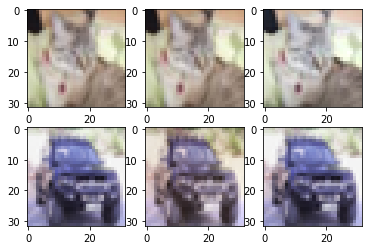

In [16]:
first, second = 4, 9
switch_operation(args, data_1[first], data_1[second], y_1_[first], y_1_[second], wolf)